# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn import datasets

c:\Users\hicha\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A}^{-1} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [5]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [220]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    """
    Bayesian Lasso with Gibbs sampling
    """
    N,P = X.shape
    # Initialize
    beta = np.zeros((Ng+1,P))
    sigma2 = np.ones(Ng)
    tau = np.ones((Ng+1,P))
  
    # Gibbs sampling 
    
    for i in range(0,Ng):
        # Sample beta
        A =  np.dot(X.T,X)+ np.linalg.inv(np.diag(tau[i]))
        B = np.dot(X.T,y)
        beta[i+1] = np.random.multivariate_normal(np.dot(np.linalg.inv(A),B), sigma2[i]*np.linalg.inv(A))
   
        # Sample tau2
        for j in range(P):
            tau[i+1,j] = ss.invgauss(mu = np.sqrt((l**2)*sigma2[i]/(beta[i+1][j]**2)), scale = 1/l**2).rvs()
            
        # Sample sigma2
        summation = np.dot(beta[i+1].T, np.dot(np.linalg.inv(np.diag(tau[i+1])), beta[i+1]))
        sigma2[i] = ss.invgamma.rvs(a0+((N+P-1)/2), scale = b0+summation+(np.linalg.norm(y-np.dot(X,beta[i+1]))**2)/2)
        
    return sigma2[Nb:], beta[Nb:], tau[Nb:]
        

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)

In [305]:
Ng = 10000
Nb = 1000
a0 = 1
b0 = 1
l = 10
sigma2, beta, tau = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)

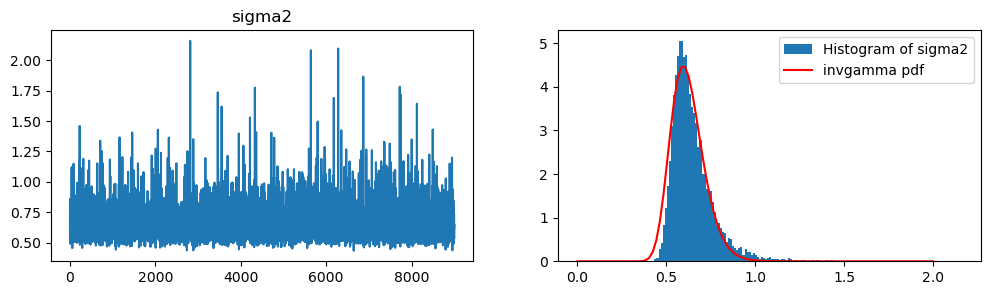

In [343]:
# Plot the sigma2 
plt.figure(figsize=(12,3))
ax = plt.subplot(121)
ax.plot(sigma2, label = 'sigma2')
ax.set_title('sigma2')
ax = plt.subplot(122)
_ = ax.hist(sigma2, bins = 150, density = True,label='Histogram of sigma2')
# afficher la loi gamma de paramètres a0 et b0
x = np.linspace(0, 2, 100)
ax.plot(x, ss.invgamma.pdf(x, 46, scale = 28), 'r', label = 'invgamma pdf')
plt.legend()
plt.show()

__Remarque__ : D'après le traceplot de $\sigma^2$ on remarque que l'algotithme converge, en plus le histogrammes de $\sigma^2$ ressemble à une loi inverse Gamma, on peut donc dire que la loi posterior de $\sigma^2$ est une loi conjuguée. La courbe en rouge est une simple approximation de la loi posterior de $\sigma^2$ par une loi inverse Gamma (46,28), une autre remarque aussi est que l'algorithme Gibbs converge un peu plus lentement car on change un seul paramètre à la fois.

Pour les paramètres $\beta$ on peut tracer les boxplots pour voir la distribution de chaque paramètre:

Text(0.5, 1.0, 'Boxplots of the coefficients')

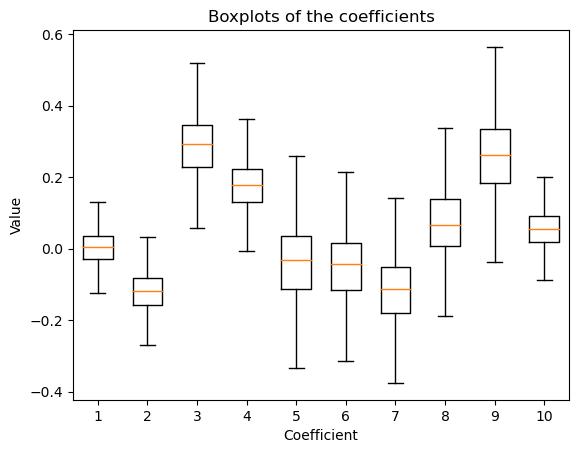

In [223]:
# Plot des boîtes à moustaches (boxplots) pour chaque coefficient
_  = plt.boxplot(beta, positions=[i+1 for i in range(len(beta[0]))], widths=0.6, showfliers=False)
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.title('Boxplots of the coefficients')

__Remarque__ : D'après les boxplots on peut s'attendre à ce que tous les paramètres $\beta_j$ soient des distributions unimodale, l'idée est donc de comparer les estimateurs MMSE et MAP avec la solution venant de l'approche fréquentiste à savoir la régularisation LASSO et la MSE.

In [345]:
# On calcule valuers de beta avec Lasso et Least square
from sklearn.linear_model import Lasso

# Lasso
reg_lasso = Lasso(alpha=(1/l)**2).fit(X, y)
print(reg_lasso.coef_)

# least square
beta_ls = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y))
print(beta_ls)

[-0.         -0.12674211  0.32332151  0.18632706 -0.07874835 -0.
 -0.1270052   0.01693767  0.32037508  0.0353998 ]
[-0.00618437 -0.1481322   0.32109626  0.20037049 -0.48931879  0.29447786
  0.06241353  0.10936955  0.46405256  0.04177106]


On peut voir que l'algorithme Lasso a tendance à mettre à zéro les paramètres $\beta_j$ qui sont les moins importants qu'est ce qui est attendu de cette méthode, par contre l'algorithme Least square a tendance à donner des valeurs non nulles pour tous les paramètres $\beta_j$.

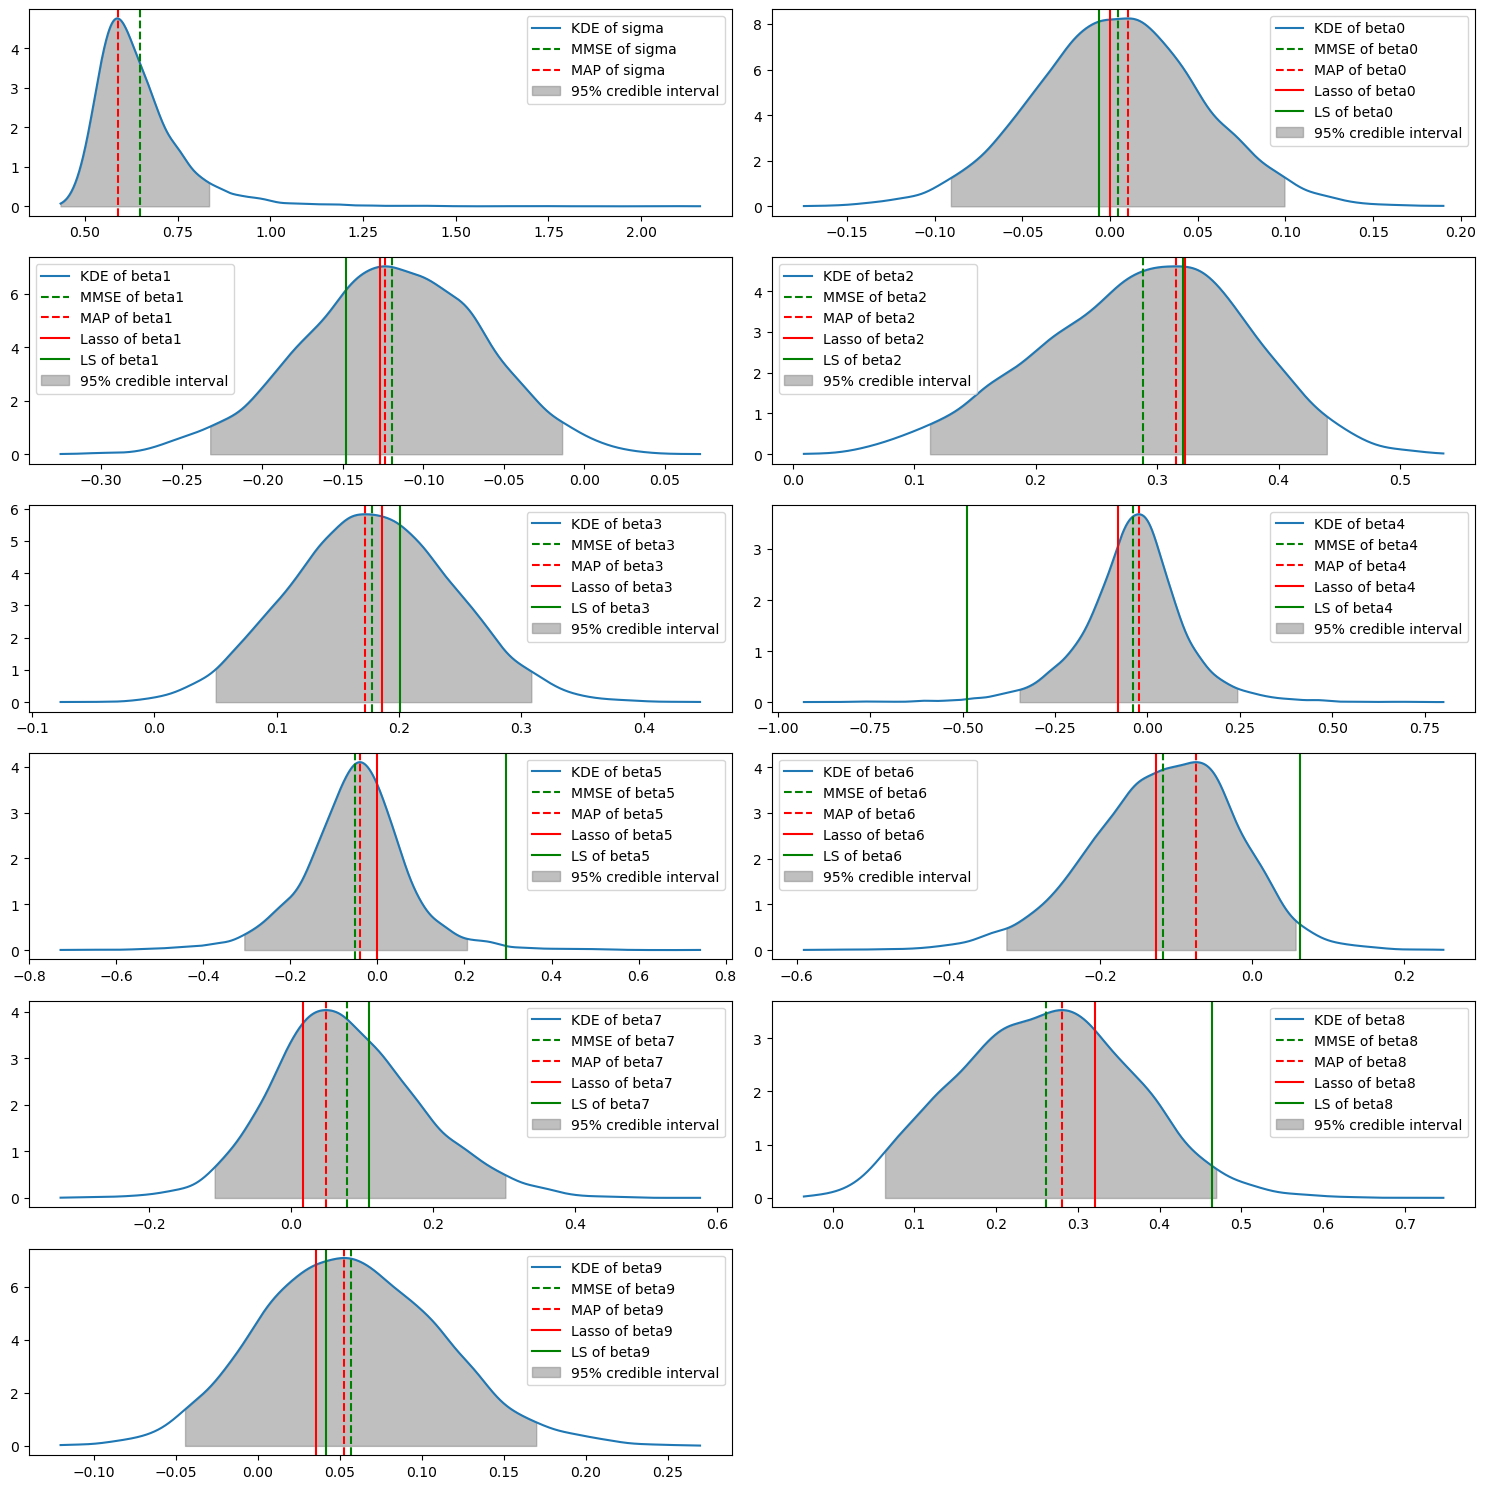

In [346]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(6, 2, 1)
kde = ss.gaussian_kde(sigma2)
x = np.linspace(np.min(sigma2), np.max(sigma2), 1000)
density = kde(x)
MAP = x[np.argmax(density)]
MMSE = np.mean(sigma2)
ax.plot(x, density, label='KDE of sigma')
ax.axvline(x=MMSE, color='g', linestyle='--', label='MMSE of sigma')
ax.axvline(x=MAP, color='r', linestyle='--', label='MAP of sigma')
# credible interval 95% (colore la regione di confidenza) centred on th map value
ax.fill_between(x, density, where=(x >= MAP-1.96*np.std(sigma2)) & (x <= MAP+1.96*np.std(sigma2)), alpha=0.5, color='grey', label='95% credible interval')
ax.legend()

for i in range(10):
    ax = plt.subplot(6, 2, i + 2)
    # Plot KDE
    kde = ss.gaussian_kde(beta[:, i])
    x = np.linspace(np.min(beta[:, i]), np.max(beta[:, i]), len(beta[:, i]))
    density = kde(x)
    MAP = x[np.argmax(density)]
    MMSE = np.mean(beta[:, i])
    ax.plot(x, density, label='KDE of beta'+str(i))
    ax.axvline(x=MMSE, color='g', linestyle='--', label='MMSE of beta'+str(i))
    ax.axvline(x=MAP, color='r', linestyle='--', label='MAP of beta'+str(i))
    ax.axvline(x=reg_lasso.coef_[i], color='r', label='Lasso of beta'+str(i))
    ax.axvline(x=beta_ls[i], color='g', label='LS of beta'+str(i))
    # credible interval 95%  centré en la valeur MAP avec les quantiles
    credible_interval = np.quantile(beta[:, i], [0.025, 0.975])
    ax.fill_between(x, density, where=(x >= credible_interval[0]) & (x <= credible_interval[1]), alpha=0.5, color='grey', label='95% credible interval')
    ax.legend()
plt.tight_layout()
plt.show()

__Remarques__ : 
1. Tous les distributions des paramètres $\beta_j$ sont unimodales.
2. les distributions à posteriori des paramètres $\beta_j$ ne ressemblent pas tous à des distributions gaussiennes, Pour $\beta_4$ et $\beta_5$ qui ressemblent à une loi de laplace (conjugate prior). La distribution de $\beta_7$ ressemble fortement à une inverse gaussian. Les lois des paramètres $\beta_1$ et $\beta_2$ et $\beta_9$ ressemblent à des distributions gaussiennes.
3. Tous les estimateurs MMSE et MAP sont très proches, on pense que c'est du au fait que les distributions à posteriori des paramètres $\beta_j$ sont unimodales.
4. Les estimateurs Lasso sont tous proches des estimateurs MAP comme suggère la théorie.  ils sont tous la zone de l'intervalle de crédibilité à 95% centré autour de l'estimateur MAP.
5. Certains estimateurs Least square sont en dehors de l'intervalle de crédibilité  ($\beta_4$ et $\beta_5$ et $\beta_6$ et $\beta_8$ ).

Ce qu'est intéressant avec cette approche bayesienne c'est qu'on peut avoir une estimation de l'incertitude sur les paramètres $\beta_j$ donc sur notre modèle et notre prédiction et ce qui va dimmuner le sur apprentissage. Choisir une seule valeur pour les paramètres $\beta_j$ ( ou plug-in approximation) est une approche très restrictive qui peut etre un pauvre resumé de la distribution à posteriori surtout dans notre cas le mode d'une distribution qu'est n'est pas un estimateur robuste.

Dans cette deuxième partie on va voir la loi prédictive à posteriori :

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

Loi prédictive a posteriori : $$p(y_{\text{new}} | \mathbf{x}_{\text{new}}, \mathcal{D}) = \int p(y_{\text{new}} | \mathbf{x}_{\text{new}}, \boldsymbol{\beta}, \sigma^2) p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D}) d\boldsymbol{\beta} d\sigma^2$$
Approximation par Monte Carlo : $$p(y_{\text{new}} | \mathbf{x}_{\text{new}}, \mathcal{D}) \approx \frac{1}{N_g} \sum_{i=1}^{N_g} p(y_{\text{new}} | \mathbf{x}_{\text{new}}, \boldsymbol{\beta}^{(i)}, \sigma^{2(i)})$$
Avec le modèle : $$y_{\text{new}} | \mathbf{x}_{\text{new}}, \boldsymbol{\beta}, \sigma^2 \sim \mathcal{N}(\mathbf{x}_{\text{new}}^{\top} \boldsymbol{\beta}, \sigma^2)$$

In [347]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])

In [240]:
# générer 5000 echantillons de beta et sigma2
sigma2_samples, beta_samples, tau_samples = bayesian_lasso_gibbs(X, y, Ng=10000, Nb=5000, a0=1, b0=1, l=10)

y_new avec la moyenne de bayes = -0.13548136422508547
y_new avec la moyenne de lasso = -0.38608247173269905
y_new avec la moyenne de MSE = -0.5410269975396854


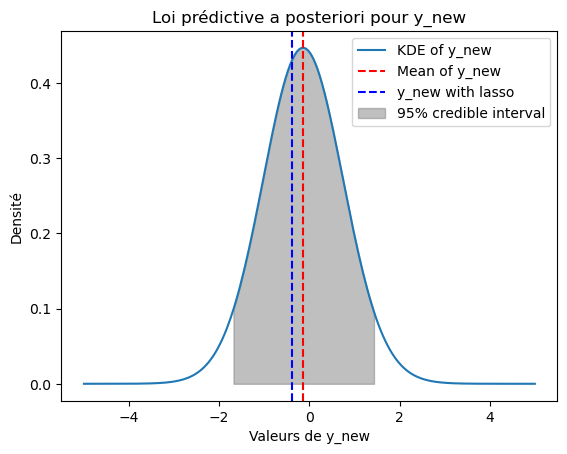

In [301]:
y_values = np.linspace(-5, 5, 200)
y_new_dist = np.zeros(len(y_values))
# On calcule et on somme la densité de la loi normale pour chaque valeur de beta et sigma2
for i in range(len(sigma2_samples)):
    # On calcule la densité de la loi normale pour chaque valeur
    y_new_dist+=ss.norm.pdf(y_values, loc=np.dot(x_new, beta_samples[i]), scale=np.sqrt(sigma2_samples[i]))/len(sigma2_samples)
     
y_new = np.sum(y_values*y_new_dist)/sum(y_new_dist)
y_new_lasso = np.dot(x_new, reg_lasso.coef_)
y_new_MSE = np.dot(x_new, beta_ls)
print('y_new avec la moyenne de bayes =', y_new)
print('y_new avec la moyenne de lasso =', y_new_lasso)
print('y_new avec la moyenne de MSE =', y_new_MSE)
 
plt.plot(y_values, y_new_dist, label='KDE of y_new')
plt.axvline(x=y_new, color='r', linestyle='--', label='Mean of y_new')
plt.axvline(x=y_new_lasso, color='b', linestyle='--', label='y_new with lasso')
# credible interval 95% centré sur y_new
ecarttype = np.sum((y_values-y_new)**2*y_new_dist)/sum(y_new_dist)
lower_bound = y_new-1.96*ecarttype
upper_bound = y_new+1.96*ecarttype
plt.fill_between(y_values, y_new_dist, where=(y_values >= lower_bound) & (y_values <= upper_bound), alpha=0.5, color='grey', label='95% credible interval')
plt.title('Loi prédictive a posteriori pour y_new')
plt.xlabel('Valeurs de y_new')
plt.ylabel('Densité')
plt.legend()
plt.show()

__Remarque__ : On peut voir que la loi prédictive a posteriori est une loi gaussienne centrée autour de la valeur y_new = -0.13, on remarque aussi que sa region de confiance contient les valeurs de y_new générées par l'algorithme Least square et Lasso (y_new = -0.38, y_new = -0.54), et cela qu'est intéressant avec l'approche bayesienne c'est qu'on peut avoir une estimation de l'incertitude sur notre prédiction. En plus en integrant sur les paramètres $\beta_j$ et $\sigma^2$ on eviter le sur apprentissage car c'est comme on fait une prédiction pour tous les modèles possibles.
Notre but est donc de minimser l'incertitude sur notre prédiction et donc de ²minimiser l'incertitude sur les paramètres $\beta_j$ et $\sigma^2$ ou bien de trouver la valeur de $lambda$ qui minimise la variance de la loi prédictive a posteriori.

**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

__Réponse :__ On peut utiliser l'algorithme EM pour estimer $\lambda$ ; 

Ce qu'on veut est maximiser la vrai vraisemblance $p(\mathcal{D} | \lambda)$ par rapport à $\lambda$ , c'est impossible de le faire directement donc on peut passer par l'algorithme EM en considérant les paramètres $\beta_j$ et $\sigma^2$ comme des variables cachées.

1. On  échantillon les parameters $\boldsymbol{\beta}$ et $\sigma^2$ à partir de la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$ en fixant $\lambda^k$ à l'aide de l'échantillonneur de Gibbs. (estimation de $p(z_n ;\mathcal{D}, \lambda^k)$)
2. On calcule $\lambda^{k+1}$ qui maximisant la vraisemblance $p(\mathcal{D} | \lambda)$ en fixant les paramètres $\boldsymbol{\beta}$ et $\sigma^2$ à l'aide de la formule suivante : $$\lambda^{k+1} = \arg\max_{\lambda} \sum_{n=1}^N \mathbb{E}_{p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})} \left[ \log p(z_n ,\mathcal{D}; \lambda) \right]$$


In [233]:
# Définir une plage de valeurs pour lambda
lambda_values = [0.1, 1.0, 5.0, 10.0,20,30,40,50.0]
beta_samples_list = []
sigma2_samples_list = []
for l in lambda_values:
    # Échantillonner avec la valeur actuelle de lambda
    sigma2_samples, beta_samples, _ = bayesian_lasso_gibbs(X, y, Ng=1000, Nb=100, a0=1, b0=1, l=l)
    # Stocker les résultats
    beta_samples_list.append(beta_samples)
    sigma2_samples_list.append(sigma2_samples)

##### Analyse de l'évolution des estimateurs MAP en fonction de lambda : 

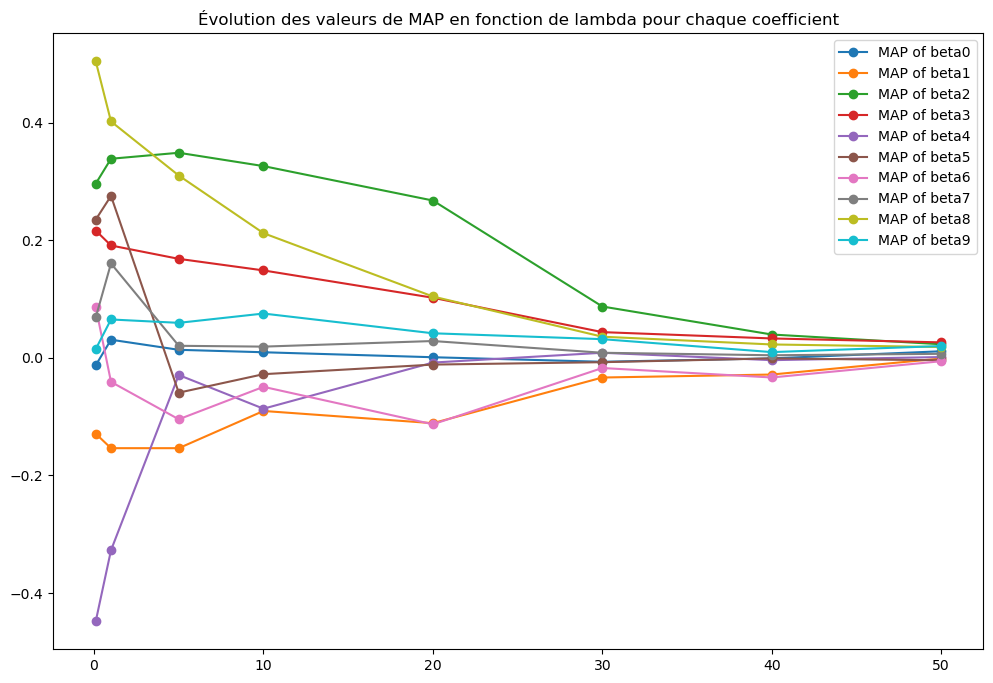

In [234]:
## afficher MAP et MMSE pour chaque lambda
plt.figure(figsize=(12, 8))
for coefficient in range(len(beta_samples_list[0][0])):
    MAP = []
    MMSE = []
    for i, l in enumerate(lambda_values):
        beta_coefficient = np.array(beta_samples_list[i])[:, coefficient]
        ## calculer MAP
        hist, bins = np.histogram(beta_coefficient, bins=150, density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        MAP.append(bin_centers[np.argmax(hist)])

    #plt.plot(lambda_values, MAP, label=f'MAP of beta{coefficient}')
    plt.plot(lambda_values, MAP, label=f'MAP of beta{coefficient}', marker='o')
    plt.legend()
    plt.title("Évolution des valeurs de MAP en fonction de lambda pour chaque coefficient")

__Remarque__ : On peut voir que les estimateurs MAP se rapprochent de zero quand lambda augmente, ce qui est attendu car on a une pénalisation en norme 1, donc plus lambda augmente plus on a une pénalisation forte et donc les estimateurs MAP se rapprochent de zero. Il faut noter que la converge n'est pas smooth car on a une pénalisation en norme 1.

##### Analyse de l'évolution des estimateurs MMSE en fonction de lambda : 

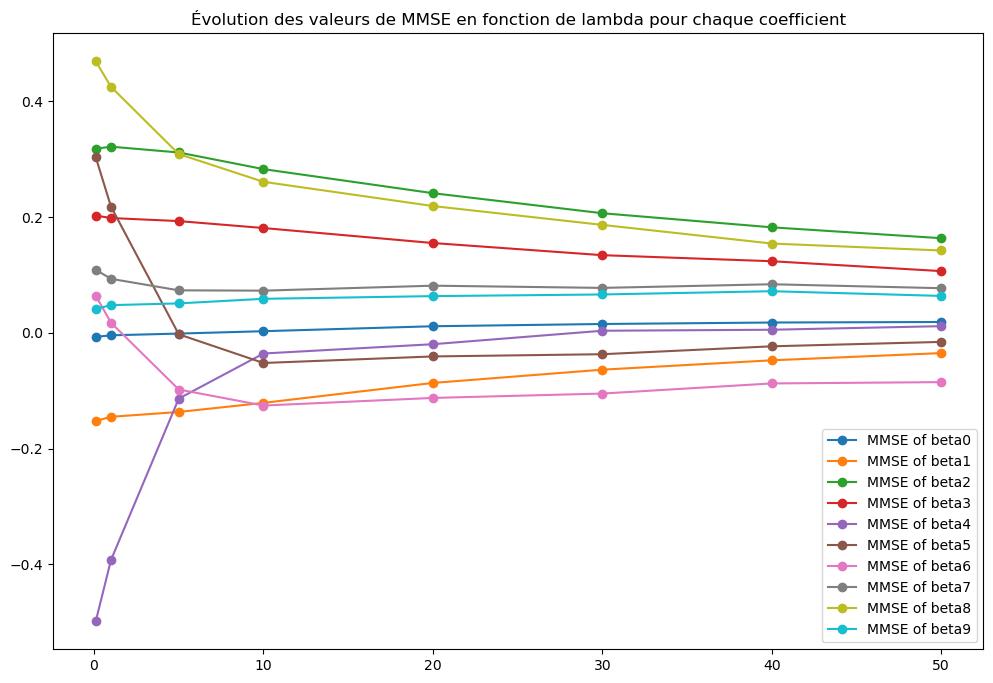

In [235]:
## afficher MAP et MMSE pour chaque lambda
plt.figure(figsize=(12, 8))

for coefficient in range(len(beta_samples_list[0][0])):
    MAP = []
    MMSE = []
    for i, l in enumerate(lambda_values):
        MAP.append(np.mean(beta_samples_list[i][:, coefficient]))
        MMSE.append(np.mean(beta_samples_list[i][:, coefficient]))
    #plt.plot(lambda_values, MAP, label=f'MAP of beta{coefficient}')
    plt.plot(lambda_values, MMSE, label=f'MMSE of beta{coefficient}', marker='o')
    plt.legend()
    plt.title("Évolution des valeurs de MMSE en fonction de lambda pour chaque coefficient")

__Remarque__ : On peut voir que les estimateurs MMSE diminuent quand lambda augmente mais pas jusqu'à zero, ce qui est attendu car on a une pénalisation en norme 2, avec une convergence plus smooth que les estimateurs MAP.

##### Analyse de l'évolution de la variance des loi à posteriori en fonction de lambda : 

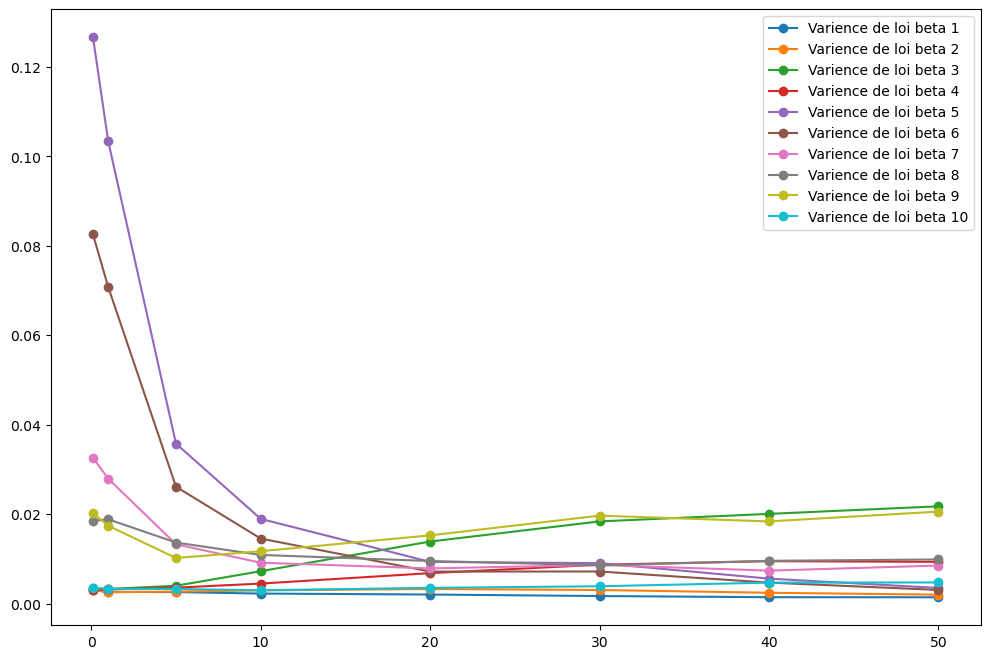

In [348]:
## afficher la variance des coefficients en fonction de lambda
plt.figure(figsize=(12, 8))

for coefficient in range(len(beta_samples_list[0][0])):
    variance_coefficient = []
    for i, l in enumerate(lambda_values):
        variance_coefficient.append(np.var(beta_samples_list[i][:, coefficient]))
    plt.plot(lambda_values, variance_coefficient, label=f'Varience de loi beta {coefficient + 1}', marker='o')
    plt.legend()

__Remarque__:La variance des loi à posteriori présente une quantification de la incertitude sur les paramètres, On voit donc que notre incertitude diminue quand lambda augmente jusqu'à un certain point de $\lambda$ ( $\lambda = 15$) et après elle augmente. Donc un critère de choix de $\lambda$ est de choisir la valeur de $\lambda$ qui minimise la variance de la loi à posteriori.

##### Analyse de l'évolution de bruit en fonction de lambda  : 

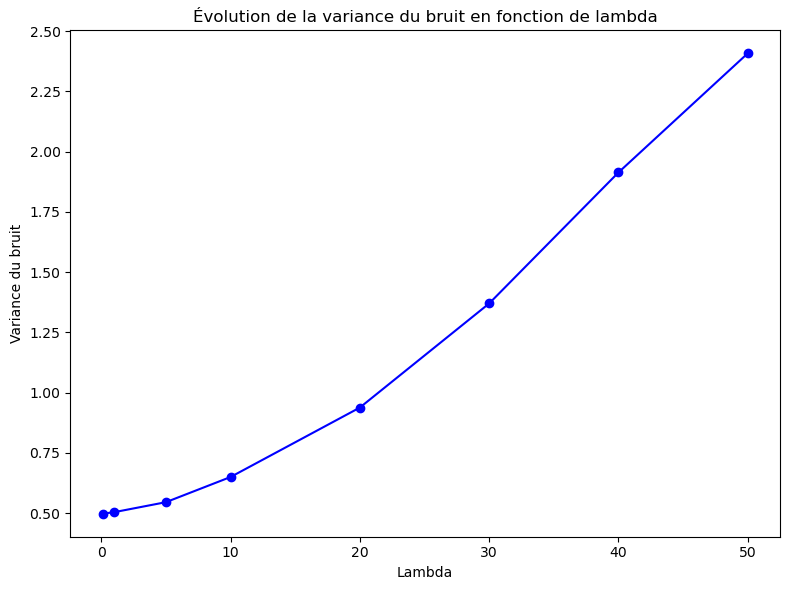

In [237]:
plt.figure(figsize=(8,6))

# Calculer la moyenne de la variance du bruit pour chaque valeur de lambda
variance_evolution = [np.mean(sigma2_samples) for sigma2_samples in sigma2_samples_list]
# Plot de la variance du bruit en fonction de lambda
plt.plot(lambda_values, variance_evolution, marker='o', linestyle='-', color='b')
plt.title("Évolution de la variance du bruit en fonction de lambda")
plt.xlabel("Lambda")
plt.ylabel("Variance du bruit")
plt.tight_layout()
plt.show()

__Remarque__ : On peut voir que le bruit augmenter quand lambda augmente mais on arrive pas à  expliquer ce constat mathématiquument

__Conclusion__ :  Ce TP a illustré de manière pratique un exemple de l'approche bayésienne, en particulier le Lasso bayésien, et l'a comparé à son équivalent dans l'approche fréquentiste. Nous avons observé que l'approche bayésienne offre la possibilité d'estimer l'incertitude associée aux paramètres $\beta_j$ et $\sigma^2$. Malgré les avantages de l'approche bayésienne en termes d'estimation de l'incertitude, l'approche fréquentiste demeure plus rapide et plus simple à mettre en œuvre. Il est également important de noter que le choix du paramètre $\lambda$ revêt une grande importance, car il influence directement l'incertitude associée aux paramètres  $\beta_j$ et $\sigma^2$, et par conséquent, notre capacité à faire des prédictions fiables ce qu'est possible de le faire en utilisant l'algorithme EM.

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).